## Summary 
The CFPB receives several thousands complaints filed by consumers each year concerning the practices of finanical companies. After reviewing each complaint, the CFPB makes a judgement regarding how the complaint should be resolved. These resolutions historically fall into seven categories with the most punitive being 'closed with monetary relief'. 

The CFPB makes the data available (making sure to anonomyze personally, identifiable, information) for the purpose of public education. Each complaint in the database contains information on the date of the complaint, consumer, location(city, state, zip code), company addressed by the complaint, type of financial product, a specific type of financial instrument issued, and a complaint narrative.  The compalaint narrative is an insightful and useful feature of the data set. Understanding the explicit trends present in the data is one step in identifying which companies to avoid and which types of products should be avoided. However, if it is also possible to understand the context of the event, through the complaint narrative, then we may be able to apply features learned from that context to a similar situation.

#### Goal
The goal of this project is to use Natural Language Processing to predict which complaints are resolved through closure with monetary relief. I use a bag-of-words approach to convert the text into a suitable format for a machine learning classifier. Ultimateley, predicting how complaints closed using NLP results in strong perforamnce.   

## Exploratory Analysis
This section details of the exploratory analysis, data wrangling, and data management. 

The data was downloaded in a .csv file from the CFPB website and I read the csv file directly into a pandas dataframe.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

#read saved csv file
conComplaintDf=pd.read_csv("Consumer_Complaints.csv",converters={'ZIP code': lambda x: str(x)})

#ccDf=conComplaintDf.groupby(['Company response to consumer']).count()

Recode the resolutions as integers from 0-8. Recoding should make it easier to explore the data and use with machine learning algorithms.

In [2]:
#order the responses
#0 closed with monetary relief
#1 closed with non-monetary relief
#2 closed with relief
#3 closed with explanation
#4 closed
#5 closed without relief
#6 untimely response
#7 in progress
conComplaintDf['respCode']=np.where(conComplaintDf['Company response to consumer']== 'Closed with monetary relief',0,
    np.where(conComplaintDf['Company response to consumer']== 'Closed with non-monetary relief',1,
        np.where(conComplaintDf['Company response to consumer']== 'Closed with relief',2,
            np.where(conComplaintDf['Company response to consumer']== 'Closed with explanation',3,
                np.where(conComplaintDf['Company response to consumer']== 'Closed',4,
                    np.where(conComplaintDf['Company response to consumer']== 'Closed without relief',5,
                        np.where(conComplaintDf['Company response to consumer']== 'Untimely response',6,
                            np.where(conComplaintDf['Company response to consumer']== 'In progress',7,8))))))))

The data received field should be adjusted to a python datetime format

In [3]:
#clean the date received field
#convert 'date received' column from string to datetime
#align all complaints to end of month 
#create a month-year column

import calendar
import datetime

#conComplaintDfStg['Date received'].dtype
conComplaintDf['dateRec']=pd.to_datetime(conComplaintDf['Date received'])#,format='%B/%d/%y')
conComplaintDf['adjDate'] = conComplaintDf['dateRec'].map(
    lambda x: datetime.datetime(
        x.year,
        x.month,
        max(calendar.monthcalendar(x.year, x.month)[-1][:5])
    )
)
conComplaintDf['monYear']=conComplaintDf['adjDate'].apply(lambda x: x.strftime('%B-%Y'))


There are three response codes(6, 7, 8) that indicate the entire process was not completed.

In [8]:
#drop rows without complete information(6&7) create data frames for data analysis

#conComplaintDfStg=
conComplaintDf.drop(conComplaintDf[conComplaintDf.respCode >=6].index, inplace=True)
conComplaintDf['zip3']=conComplaintDf['ZIP code'].str[:3]


#create dataframe with complaints resulting in monetary relief
#response0Df=conComplaintDf.loc[(conComplaintDf.respCode== 0)]
                               

I downloaded and saved the CFPB complaint database but we could download from the website and load directly into a pandas dataframe.  Below I load census files directly into pandas dataframes from their host websites.

In [9]:
#download urban area to cbsa file
#UA:urban area number
#UANAME: urban area name
#CBSA: corebased statistical area number(micro/metropolitan statistical area)
#MNAME: cbsa name
#MEMI: 1=metropolitan statistical area; 2=micropolitan statistical area
url="https://www2.census.gov/geo/docs/maps-data/data/rel/ua_cbsa_rel_10.txt"
uaToCbsaDf=pd.read_csv(url,encoding='latin1')#converters={'ZCTA5': lambda x: str(x)})
uaToCbsaDf=uaToCbsaDf[['UA','UANAME','CBSA','MNAME','MEMI','POPPT']]
uaToCbsaDf.drop(uaToCbsaDf[(uaToCbsaDf.MEMI != 1) | (uaToCbsaDf.UA== 99999)|(uaToCbsaDf.CBSA==99999) ].index, inplace=True)



In [10]:
#download zip to cbsa file

import urllib.request
import requests
import io
url="https://www2.census.gov/geo/docs/maps-data/data/rel/zcta_cbsa_rel_10.txt"
#zipToSaDf=pd.read_csv(url,'ZCTA5',index_col=0)
#preserve leading zeros in zip5
zipToSaDf=pd.read_csv(url,converters={'ZCTA5': lambda x: str(x)})
zipToSaDf=zipToSaDf[['ZCTA5','CBSA','ZPOP','MEMI']]
zipToSaDf.drop(zipToSaDf[(zipToSaDf.MEMI)!=1].index,inplace=True)
zipToSaDf['zip3']=zipToSaDf.ZCTA5.str[:3]


In [11]:
#some records contain zip5 and some contain zip3.  This causes problems when merging
#I will split the cfpb data into two files
#1- with full 5-digit zip code
#2- with 3-digit zip code
conComplaintZ5=conComplaintDf[conComplaintDf['ZIP code'].str.contains("XX")==False]

conComplaintZ3=conComplaintDf[conComplaintDf['ZIP code'].str.contains("XX")==True]


In [12]:
#later we will use zip codes to merge with census files(urban area and msa)
#since zip3 is truncated zip5, they may link with multiple zip5s and UA/MSA
#I want to remove the smaller(by population) instances of zip3
#sort by zip3 and zip-level population
#goal is to keep zip3 with largest population 
zipToSaDf.sort_values(['zip3','ZPOP'])
zipToSaDfZ3=zipToSaDf.drop_duplicates(['zip3'],keep='last')


The next steps are focused on merging the census files to create a normalized dataset.

In [13]:
#merge the zip To CBSA file onto the split(by zip3 and zip5) consumer complaint data
cfpbComplaintCbsaZ5= pd.merge(conComplaintZ5,zipToSaDf,left_on=['ZIP code','zip3'],right_on=['ZCTA5','zip3'],how='left')
cfpbComplaintCbsaZ3= pd.merge(conComplaintZ3,zipToSaDfZ3,on=['zip3'],how='left')


In [14]:
#concatenate the zip5 and zip3 files
cfpbComplaintCbsa= pd.concat([cfpbComplaintCbsaZ5,cfpbComplaintCbsaZ3])

Since UA to CBSA is a 'one to many' relationship, I'm going to keep the CBSA with largest population for this exercise.  The idea, is that there is a greater probability of the consumer residing in the CBSA with a larger population.

In [15]:
#UA to CBSA is a 'one to many' relationship. keep CBSA with largest population for this exercise
uaToCbsaDf.sort_values(['CBSA','POPPT'],inplace=True)
uaToCbsaDf=uaToCbsaDf.drop_duplicates(['CBSA'],keep='last')

I need to change the data type from float to int for merging

In [16]:
#change the dtype from float to int
cfpbComplaintCbsa['CBSA']=cfpbComplaintCbsa['CBSA'].fillna(0.0).astype(int)

In [17]:
#now merge with the uaCbsa data to add urban area information
cfpbComplaintCbsaUa=pd.merge(cfpbComplaintCbsa,uaToCbsaDf, on='CBSA', how = 'inner')

#### Visualizing Complaints
I want to visualize the location of complaints.  To this end,  I download a lattitude/longitude coordinates from the census gazetteer files. This gazetteer files will map to my other census files using Urban Area as a key. Downloading a zip file and loading into pandas is a bit different (and not as straight forward) than what I did above.

In [18]:
from zipfile import ZipFile
from urllib.request import urlopen   
import pandas as pd
import os

URL = \
    'http://www2.census.gov/geo/docs/maps-data/data/gazetteer/Gaz_ua.zip'

# open and save the zip file onto computer
url = urlopen(URL)
output = open('zipFile.zip', 'wb')    # note the flag:  "wb"        
output.write(url.read())
output.close()

# read the zip file as a pandas dataframe
uaGaz = pd.read_csv('zipFile.zip',sep='\t',encoding='latin1')   # pandas version 0.18.1 takes zip files       

# if keeping on disk the zip file is not wanted, then:
#os.remove(zipName)   # remove the copy of the zipfile on disk

In [19]:
#keep ID, Lat, Long fields and merge onto cfpb data
#uaGaz.count()
#uaGaz=uaGaz[['GEOID','INTPTLAT','INTPTLONG']]
gazCols=['GEOID','NAME',
 'UATYPE',
 'POP10',
 'HU10',
 'ALAND',
 'AWATER',
 'ALAND_SQMI',
 'AWATER_SQMI',
 'INTPTLAT',
 'INTPTLONG']
uaGaz.columns=gazCols
cfpbComplaintCbsaUaLl= pd.merge(cfpbComplaintCbsaUa,uaGaz,left_on='UA',right_on='GEOID',how='left')


In [20]:
cfpbComplaintCbsaUaLl.iloc[:,-1]
cfpbComplaintCbsaUaLl.rename(columns={'INTPTLONG\n':'INTPTLONG'}, inplace=True)

In [40]:
#just for mapping 
map_data=cfpbComplaintCbsaUaLl[['UA','INTPTLAT','INTPTLONG']].groupby(['UA','INTPTLONG','INTPTLAT']).size().reset_index(name='counts')

/home/augustine/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/augustine/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/augustine/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


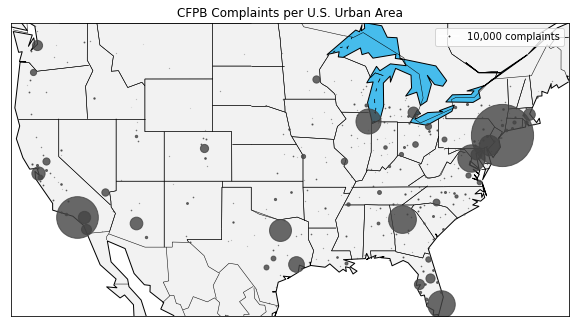

In [303]:
import matplotlib.pyplot as plt
import matplotlib.cm
import matplotlib.patches as mpatches
from matplotlib.patches import Circle
from matplotlib.lines import Line2D

from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

fig, ax = plt.subplots(figsize=(10,20))

m= Basemap(resolution='c', # c, l, i, h, f or None
            projection='merc',
            lat_0=-90, lon_0=49,
            llcrnrlon=-125., llcrnrlat= 25, urcrnrlon=-67, urcrnrlat=49)

m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.drawcountries()
m.drawstates()
plt.title('CFPB Complaints per U.S. Urban Area')

#gt = mpatches.Circle((1,1),1,color='#444444',label='10,000 complaints')
#plt.legend(handles=[gt], loc=3)
#plt.legend(['ro'],['1,000 complaints'])
#plt.legend([red_dot, (red_dot, white_cross)], ["Attr A", "Attr A+B"])



line1 = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="#444444", markersize=3)

plt.legend([line1],['10,000 complaints'],numpoints=1, loc=1)

def plot_area(line):
    count = line.counts#loc[new_areas.pos == pos]['count']
#x,y= m(line.INTPTLONG,line.INTPTLAT)
    lon= line.iloc[0]['INTPTLONG']#[0::1] #-114.568173 #line.INTPTLONG
    lat= line.iloc[0]['INTPTLAT']#32.676904#ine.INTPTLAT
    x,y= m(lon,lat)
    size = (count/1000)#+1 #** 2 + 3
    m.plot(x, y, 'o', markersize= size, color='#444444', alpha=0.8)


#size
    
#map_data[['INTPTLONG','INTPTLAT','counts']].apply(plot_area)
numRows= map_data['counts'].size

#map_data.apply(plot_area)
for i in range(1,numRows):
    plot_area(map_data[i-1:i])
    

#### Text Processing
Below I take care of missing values and recode categorical values into binary


In [23]:
cfpbComplaintCbsaUaLl['target']=np.where(cfpbComplaintCbsaUaLl['respCode']== 0,1,0)

In [ ]:
#transform categorical variables into 1/0's
#catCols= ['State','Product','Issue','UA']
#cfpbWDummies=pd.get_dummies( cfpbComplaintCbsaUaLl,columns=catCols)

In [24]:
#Text processing replace na with an empty string
cfpbComplaintCbsaUaLl['Consumer complaint narrative']= cfpbComplaintCbsaUaLl['Consumer complaint narrative'].fillna('')
cfpbComplaintCbsaUaLl['State']= cfpbComplaintCbsaUaLl['State'].fillna('')
#transform categorical variables into binary
cfpbComplaintCbsaUaLl['UA']=cfpbComplaintCbsaUaLl['UA'].astype('category')
#catCols= ['State','Product','Issue','UA']
catCols= ['Product','Issue','UA']
dfDummies= pd.get_dummies(cfpbComplaintCbsaUaLl[catCols])
dataStg= pd.concat([cfpbComplaintCbsaUaLl,dfDummies],axis=1)


Below is a function where I remove html tags, remove numbers so we are left with text, convert all text to lowercase, stem words, and remove stopwords.

In [25]:
#define function to process raw text one record at a time
from bs4 import BeautifulSoup
import re 
from nltk.stem import PorterStemmer 
ps= PorterStemmer()
from nltk.corpus import stopwords 

def processText(raw):
#remove tags
    text = BeautifulSoup(raw,'lxml')
#remove numbers so we only have text    
    letters= re.sub("[^a-zA-Z]"," ",text.get_text())
#change everything to lower case and split 
    lowerCase= letters.lower()
#stem lower case letters
    stems= ps.stem(lowerCase).split()
#remove common words using nltk dictionary
    stopWords= set(stopwords.words('english'))
    procdText= [j for j in stems if not j in stopWords]
#mash everything back together     
    return( " ".join(procdText))

Now I'm going to split the data into train and test sets (80/20)

In [26]:
#train/test splitting
from sklearn.model_selection import train_test_split 

#split dataStg into train/ test
train, test= train_test_split(dataStg,test_size=.2)

# recreate index in test and train sets so we can run through the text processing function
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)


Below, I imputed values for features in case they are missing from the evaluation data.

In [27]:
#create probabilities of monetary compensation for some variables
#will also impute means (based on column value) for NaN at the same time
from sklearn.preprocessing import Imputer
imp= Imputer(missing_values='NaN', strategy='mean',axis=0)

#first create data frame with monetary compansation
response0Df= train.loc[(train.respCode== 0)]
#state
#add the following state 
#stAdd= pd.Series([np.NaN],index=['AE'])
#stateAll= train.State.value_counts()
#state0=response0Df.State.value_counts()
#stateRate= state0/stateAll
#stateRate.rename('stRate',inplace=True)
#stateRateDfTemp=stateRate.to_frame()
#stateRateDf=pd.DataFrame(imp.fit_transform(stateRateDfTemp))
#stateRateDf.columns= stateRateDfTemp.columns
#stateRateDf.index= stateRateDfTemp.index
#train=pd.merge(train,stateRateDf,left_on='State',right_index=True,how='left')
#now do add the same rates to the test data set
#test=pd.merge(test,stateRateDf,left_on='State',right_index=True,how='left')
#test['stRate']=imp.transform(test[['stRate']]).ravel()

#producct
prodAll= train.Product.value_counts()
prod0=response0Df.Product.value_counts()
productRate= prod0/prodAll
productRate.rename('prdRate',inplace=True)
productRateDfTemp= productRate.to_frame()
productRateDf= pd.DataFrame(imp.fit_transform(productRateDfTemp))
productRateDf.columns= productRateDfTemp.columns
productRateDf.index= productRateDfTemp.index
train=pd.merge(train,productRateDf,left_on='Product',right_index=True,how='left')
#now do add the same rates to the test data set
test=pd.merge(test,productRateDf,left_on='Product',right_index=True,how='left')
test['prdRate']=imp.transform(test[['prdRate']]).ravel()


#issue
issAll= train.Issue.value_counts()
iss0=response0Df.Issue.value_counts()
issueRate=iss0/issAll
issueRate.rename('issRate',inplace=True)
issueRateDfTemp= issueRate.to_frame()
issueRateDf=pd.DataFrame(imp.fit_transform(issueRateDfTemp))
issueRateDf.columns= issueRateDfTemp.columns
issueRateDf.index= issueRateDfTemp.index
train=pd.merge(train,issueRateDf,left_on='Issue',right_index=True,how='left')
#now do add the same rates to the test data set
test=pd.merge(test,issueRateDf,left_on='Issue',right_index=True,how='left')
test['issRate']=imp.transform(test[['issRate']]).ravel()

#Urban Area
uaAll= train.UA.value_counts()
ua0= response0Df.UA.value_counts()
uaRate= ua0/uaAll
uaRate.rename('uaRate',inplace=True)
uaRateDfTemp= uaRate.to_frame()
uaRateDf=pd.DataFrame(imp.fit_transform(uaRateDfTemp))
uaRateDf.columns= uaRateDfTemp.columns
uaRateDf.index= uaRateDfTemp.index
train=pd.merge(train,uaRateDf,left_on='UA',right_index=True,how='left')
#now do add the same rates to the test data set
test=pd.merge(test,uaRateDf,left_on='UA',right_index=True,how='left')
test['uaRate']=imp.transform(test[['uaRate']]).ravel()


Throughout the next section, I devote more time to data exploration and understanding time and product components present in the data.

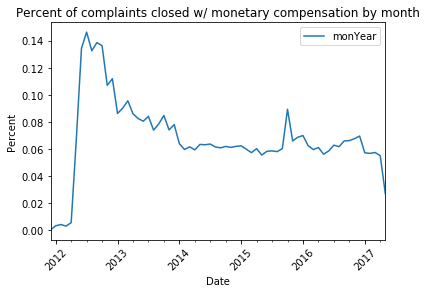

In [28]:

reliefDf= cfpbComplaintCbsaUaLl.loc[(cfpbComplaintCbsaUaLl.respCode== 0)]
monYearAll=cfpbComplaintCbsaUaLl.monYear.value_counts()
monYear0=reliefDf.monYear.value_counts()
monYearPct=monYear0/monYearAll
monYearPctDf= monYearPct.to_frame()
#monYearPctDf=
monYearPctDf.reset_index(inplace=True)
monYearPctDf['index']=pd.to_datetime(monYearPctDf['index'])
monYearPctDf.sort_values('index',inplace=True)
monYearPctDf.set_index('index',inplace=True)
#resp0MonYearPct
#monYearPctDf
monYearPctDf.plot(kind='line',title='Percent of complaints closed w/ monetary compensation by month')
plt.xticks(rotation=45)
#fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Percent')
plt.show()



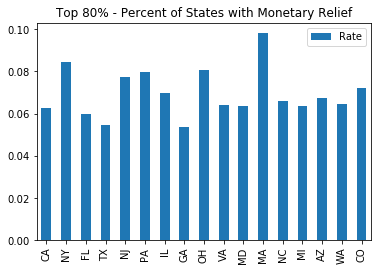

In [29]:
stAll= cfpbComplaintCbsaUaLl.State.value_counts()
stRelief=reliefDf.State.value_counts()

stReliefDf=stRelief.to_frame()
stReliefDf.sort_values('State',ascending='False')
stateRatesAll=stRelief/stAll
stateRatesAll.rename('Rate',inplace=True)
stateRatesAllDf=stateRatesAll.to_frame()

stReliefDf['cum_sum'] = stReliefDf.State.cumsum()
stReliefDf['cum_perc'] = 100*stReliefDf.cum_sum/stReliefDf.State.sum()
stReliefDf=stReliefDf[stReliefDf.cum_perc<= 80]
#issCounts=issReliefDf.Issue.value_counts()
#issCounts
#issRates=issCounts/issRelief
#issRatesDf= issRates.to_frame()

stRelief80Df= pd.merge(stReliefDf,stateRatesAllDf,left_index=True,right_index=True,how='left')

stplt=stRelief80Df[['Rate']].plot(kind='bar',title='Top 80% - Percent of States with Monetary Relief')


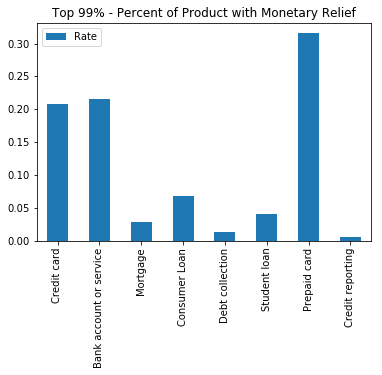

In [30]:
prodAll= cfpbComplaintCbsaUaLl.Product.value_counts()
prodRelief=reliefDf.Product.value_counts()

prodReliefDf=prodRelief.to_frame()
prodReliefDf.sort_values('Product',ascending='False')
productRatesAll=prodRelief/prodAll
productRatesAll.rename('Rate',inplace=True)
productRatesAllDf=productRatesAll.to_frame()

prodReliefDf['cum_sum'] = prodReliefDf.Product.cumsum()
prodReliefDf['cum_perc'] = 100*prodReliefDf.cum_sum/prodReliefDf.Product.sum()
prodReliefDf=prodReliefDf[prodReliefDf.cum_perc<= 99]

prodRelief80Df= pd.merge(prodReliefDf,productRatesAllDf,left_index=True,right_index=True,how='left')

prodplt=prodRelief80Df[['Rate']].plot(kind='bar',title='Top 99% - Percent of Product with Monetary Relief')

There are too much variatoin at the 'Issue' level to display all 'Issues' in a graph. I limit the graph below to top 80%.

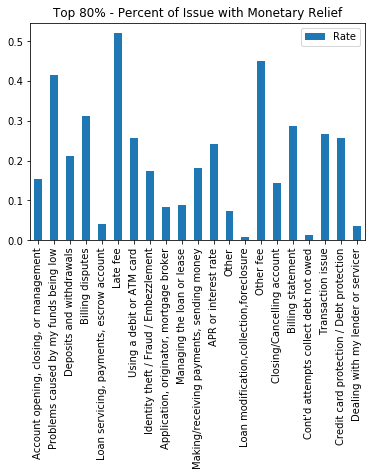

In [31]:
issAll= cfpbComplaintCbsaUaLl.Issue.value_counts()
issRelief=reliefDf.Issue.value_counts()

issReliefDf=issRelief.to_frame()
issReliefDf.sort_values('Issue',ascending='False')
issueRatesAll=issRelief/issAll
issueRatesAll.rename('Rate',inplace=True)
issueRatesAllDf=issueRatesAll.to_frame()

issReliefDf['cum_sum'] = issReliefDf.Issue.cumsum()
issReliefDf['cum_perc'] = 100*issReliefDf.cum_sum/issReliefDf.Issue.sum()
issReliefDf=issReliefDf[issReliefDf.cum_perc<= 80]

issRelief80Df= pd.merge(issReliefDf,issueRatesAllDf,left_index=True,right_index=True,how='left')

issplt=issRelief80Df[['Rate']].plot(kind='bar',title='Top 80% - Percent of Issue with Monetary Relief')


In [143]:
Don't use anymore
#add the same rates to the test data set
test=pd.merge(test,stateRateDf,left_on='State',right_index=True,how='left')
test=pd.merge(test,productRateDf,left_on='Product',right_index=True,how='left')
test=pd.merge(test,issueRateDf,left_on='Issue',right_index=True,how='left')
test=pd.merge(test,uaRateDf,left_on='UA',right_index=True,how='left')

The next section calls the text processing function that was defined earlier.

In [32]:
#loop through train data and process text
#get number of rows
numRows= train["Consumer complaint narrative"].size
print(numRows)
#init empty list
cleanText= []
#now loop through text rows
for i in range(0,numRows):
    if ((i+1)%50000 == 0 ):
        print ("processing %d of %d\n" %(i+1,numRows))
    cleanText.append(processText(train["Consumer complaint narrative"][i]))
    


575894
processing 50000 of 575894

processing 100000 of 575894

processing 150000 of 575894

processing 200000 of 575894

processing 250000 of 575894

processing 300000 of 575894

processing 350000 of 575894

processing 400000 of 575894

processing 450000 of 575894

processing 500000 of 575894

processing 550000 of 575894



In [33]:
#Do the same processing loop through text for the test data
numRows= test["Consumer complaint narrative"].size
print(numRows)
#init empty list
testText= []
#now loop through text rows
for i in range(0,numRows):
    if ((i+1)%50000 == 0 ):
        print ("processing %d of %d\n" %(i+1,numRows))
    testText.append(processText(test["Consumer complaint narrative"][i]))
    


143974
processing 50000 of 143974

processing 100000 of 143974



Below I create arrays (for test and train data) that just contain the target variable.

In [34]:
#create arrays that just contain the target variables
#these arrays are used in chi2 test
yTrain, yTest = train.target, test.target

Next I drop the features that will not be used in any algorithm.

In [35]:
#drop fields that will not be used as features

trainFt=train.drop(['Product','State','Issue','UA','Date received','Sub-product','Sub-issue','Consumer complaint narrative','Company public response',
 'Company','ZIP code','Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer',
 'Timely response?', 'Consumer disputed?', 'Complaint ID', 'respCode', 'dateRec', 'adjDate', 'monYear', 'zip3',
 'ZCTA5', 'CBSA', 'ZPOP', 'MEMI_x', 'UANAME', 'MNAME', 'MEMI_y', 'POPPT', 'GEOID', 'NAME', 'UATYPE', 'POP10',
 'HU10', 'ALAND', 'AWATER', 'ALAND_SQMI', 'AWATER_SQMI', 'INTPTLAT', 'INTPTLONG', 'target'],axis=1)
#trainFtAr=sp.sparse.csr_matrix(trainFt)

testFt= test.drop(['Product','State','Issue','UA','Date received','Sub-product','Sub-issue','Consumer complaint narrative','Company public response',
 'Company','ZIP code','Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer',
 'Timely response?', 'Consumer disputed?', 'Complaint ID', 'respCode', 'dateRec', 'adjDate', 'monYear', 'zip3',
 'ZCTA5', 'CBSA', 'ZPOP', 'MEMI_x', 'UANAME', 'MNAME', 'MEMI_y', 'POPPT', 'GEOID', 'NAME', 'UATYPE', 'POP10',
 'HU10', 'ALAND', 'AWATER', 'ALAND_SQMI', 'AWATER_SQMI', 'INTPTLAT', 'INTPTLONG', 'target'],axis=1)
#testFtAr= sp.sparse.csr_matrix(testFt)

## Models and Results

Below I begin transforming the data for use with machine learning algorithms. The first transformation is to turn the text data into tf-idf array. This conversion is done using the sci-kit learn TfidVectorizer module. Sci-kit learn uses a fit-transform method to first fit a model based on train data and then transform test data using the already fitted model.

In [36]:
#Create count vector and normalize
#TF*IDF transformation in one step
from sklearn.feature_extraction.text import TfidfVectorizer

transformer= TfidfVectorizer(ngram_range=(1,3))

tfidf= transformer.fit_transform(cleanText)#x_train_counts)
tfidf.shape

#now extract same features from test set
x_test = transformer.transform(testText)

#save feature names
featureNames= transformer.get_feature_names()

Below I use chi-square independence test to selection which features to keep.

In [37]:
#Chi-Squared selection on text features before stacking and scaling
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

ch2= SelectKBest(chi2,k=1000)

x_train = ch2.fit_transform(tfidf, yTrain)
x_train.shape


x_test_new = ch2.transform(x_test)

if featureNames:
    #update with selected feature names
    featureNames= np.asarray(transformer.get_feature_names())[ch2.get_support()]

    #featureNames = [featureNames[i] for i in ch2.get_support(indices=False)]
print(x_train.shape)
len(featureNames)

(575894, 1000)


1000

Below I combine text features with features that were identified earlier during exploratory analysis.

In [38]:
#concatenate features with nlp matrix
#stack after chi-squared selection
import scipy as sp
from scipy.sparse import hstack
#BELOW IS FOR STACKING AFTER CHI-SQUARE SELECTION
tfidfFt= sp.sparse.hstack((x_train,trainFt.values),format='csr')
x_testFt= sp.sparse.hstack((x_test_new,testFt.values),format='csr')
#BELOW IS FOR STACKING BEFORE CHI-SQUARE SELECTION
#tfidfFt= sp.sparse.hstack((tfidf,trainFt.values),format='csr')
#x_testFt= sp.sparse.hstack((x_test,testFt.values),format='csr')

In [40]:
#scale features to prepare for classifier

from sklearn import preprocessing

tfidfFtScaled= preprocessing.scale(tfidfFt, with_mean=False)
testFtScaled= preprocessing.scale(x_testFt, with_mean=False)
#foo=preprocessing.scale(testFt, with_mean=False)

In [41]:
#create new data frame for ML algorithms
x_train= tfidfFtScaled
x_test_new= testFtScaled

In [42]:

#import libraries
from time import time
from sklearn import svm 
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

#define function to run through different classifiers


def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf_type)
    if clf_type=='SVM':
        cv= StratifiedKFold(n_splits= 2)
    else:
        cv= StratifiedKFold(n_splits= 5)
    t0 = time()
    if clf_type=='SVM':
        clf.fit(x_train,yTrain)
        #print("roc_auc score: ", str(scores))
    else:
        scores= cross_val_score(clf, x_train, yTrain,cv= cv, scoring='roc_auc')
        clf.fit(x_train, yTrain)
        print("stratified 5-fold cross validation roc_auc score: ", str(scores))
    
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    #pred= cross_val_predict(clf, x_train, yTrain,cv=cv)
    pred = clf.predict(x_test_new)
    if clf_type== 'SVM':
        preds= clf.decision_function(x_test_new)
    else:
        preds = clf.predict_proba(x_test_new)[:,1]
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(yTest, pred)
    print("accuracy:   %0.3f" % score)
    
    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if featureNames is not None and clf_type is not 'SVM':
            print("top keywords:")
            top10 = np.argsort(clf.coef_[0])[-10:]
            coefs_with_fns = sorted(zip(clf.coef_[0], featureNames))
            top = zip(coefs_with_fns[:19], coefs_with_fns[:-(10 + 1):-1])
            for (coef_1, fn_1), (coef_2, fn_2) in top:
                print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
            #print("%s: %s" % (" ".join(featureNames[top10])))
                print()
        
        #def show_most_informative_features(vectorizer, clf, n=20):
            #feature_names = vectorizer.get_feature_names()
            #coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
            #top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
            #for (coef_1, fn_1), (coef_2, fn_2) in top:
                #print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
        print("classification report:")
        print(metrics.classification_report(yTest, pred))#,target_names=target_names))
        print("confusion matrix:")
        print(metrics.confusion_matrix(yTest, pred))

        
        # Compute ROC curve and ROC area for each class
        #fpr = dict()
        #tpr = dict()
        #roc_auc = dict()
        fpr, tpr, _ = metrics.roc_curve(yTest, preds)
        roc_auc = auc(fpr, tpr)

        # Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(yTest.ravel(), preds.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
        
    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time




In [38]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

logReg= LogisticRegression(penalty='l1',class_weight='balanced')
#penalty='l1',class_weight='balanced')
parameters= {'C':[.01,.1,1,10]}
#fit_params= {'C':[.1,1]}
clf= GridSearchCV(logReg,fit_params,cv=2)
score= clf.fit(x_train,yTrain)
print('Best C Parametr: ', clf.best_params_)

print (roc_auc_score(clf.predict(x_test_new),yTest))

Best C Parametr:  {'C': 0.1}
0.587891992009


In [55]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

logReg= LogisticRegression(penalty='l1',class_weight='balanced')
#penalty='l1',class_weight='balanced')
#parameters= {'C':[.01,.1,1,10]}
fit_params= {'C':[.1,1]}
clf= GridSearchCV(logReg,fit_params,cv=3)
score= clf.fit(x_train,yTrain)
print('Best C Parametr: ', clf.best_params_)

print (roc_auc_score(clf.predict(x_test_new),yTest))

Best C Parametr:  {'C': 0.1}
0.58575083749


LogReg
________________________________________________________________________________
Training: 
LogReg
stratified 5-fold cross validation roc_auc score:  [ 0.86399737  0.86475692  0.86389261  0.86577924  0.86472823]
train time: 3566.912s
test time:  0.018s
accuracy:   0.765
dimensionality: 4000
density: 0.221500
classification report:
             precision    recall  f1-score   support

          0       0.98      0.76      0.86    134383
          1       0.20      0.83      0.32      9591

avg / total       0.93      0.76      0.82    143974

confusion matrix:
[[102191  32192]
 [  1661   7930]]


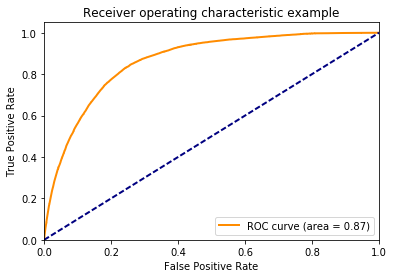

In [140]:
#load results in empty array
#best result
#unigram 4k features
results=[]

clf_type='LogReg'              
print(clf_type)               
results.append(benchmark(linear_model.LogisticRegression(C=1, penalty='l1',class_weight='balanced')))


unigram
Naive Bayes
________________________________________________________________________________
Training: 
Naive Bayes
stratified 5-fold cross validation roc_auc score:  [ 0.75359062  0.75846994  0.75537128  0.7543741   0.7597135 ]
train time: 2.383s
test time:  0.098s
accuracy:   0.923
dimensionality: 10541
density: 1.000000
top keywords:
	-21.2188	accounts section fcra		-6.7643	fee            

	-21.2188	bayview        		-6.8188	card           

	-21.2188	company file used		-6.8767	bank           

	-21.2188	delete information		-6.8848	charged        

	-21.2188	delete information verified		-6.8873	fees           

	-21.2188	disputed gone  		-6.9105	account        

	-21.2188	disputed please		-7.0201	charge         

	-21.2188	disputed please resolve		-7.0308	would          

	-21.2188	documents company file		-7.0738	charges        

	-21.2188	fcra required  		-7.1435	called         

classification report:
             precision    recall  f1-score   support

          0       

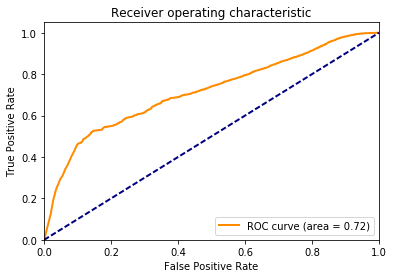

In [ ]:
#test
#load results in empty array
print('unigram')

results=[]

clf_type='Naive Bayes'
print(clf_type)
results.append(benchmark(MultinomialNB(alpha=.01)))

SVM
________________________________________________________________________________
Training: 
SVM
train time: 52906.346s
test time:  4553.887s
accuracy:   0.758
dimensionality: 4000
density: 0.883500
classification report:
             precision    recall  f1-score   support

          0       0.98      0.75      0.85    134383
          1       0.19      0.82      0.31      9591

avg / total       0.93      0.76      0.82    143974

confusion matrix:
[[101164  33219]
 [  1686   7905]]


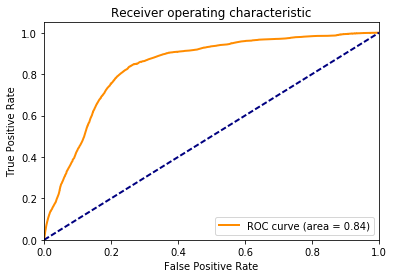

In [ ]:
results=[]

clf_type='SVM'
print(clf_type)        
results.append(benchmark(svm.SVC(kernel='linear',class_weight='balanced', C=10**(0))))

Results indicate decent performance is acheived when using NLP and geographic characteristics to predict compalaints resolved with monetary relief.  The precision and recall scores produced by the SVM and Logistic Regression indicate identifying the majority of each class. However, it also appears, based on the precision measure, that both models are overpredicting resolution with monetary relief.  Interestingly, the Naive Bayes model outperforms in this regard.